In [60]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import torch.nn.functional as F
from keras.applications import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from utils import to_grayscale_then_rgb
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense,Lambda
from keras.optimizers import Adam,SGD
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn import metrics
import keras as k

In [61]:
file_data_b_csv=r'/home/jacobo15defrutos/AVS9/4-Red_Siamesa/Code/basic_seg2.csv'
df= pd.read_csv(file_data_b_csv)
df_train, df_test = train_test_split(df, test_size=0.2,random_state=31)
print("Train shape: ",df_train.shape)
print("Test shape: ",df_test.shape)

Train shape:  (48, 2)
Test shape:  (12, 2)


Text(0.5, 1.0, 'Bar Plot of Label Counts')

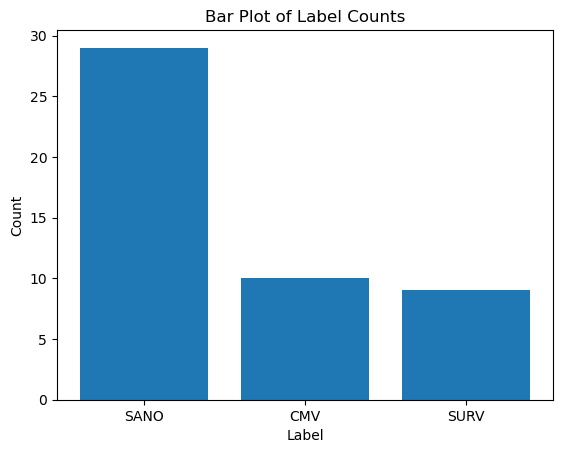

In [62]:
label_counts = df_train['Label'].value_counts()

# Create a bar plot
plt.bar(label_counts.index, label_counts.values)

# Set the labels and title
plt.xticks(label_counts.index, ["SANO","CMV", "SURV"])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Bar Plot of Label Counts')

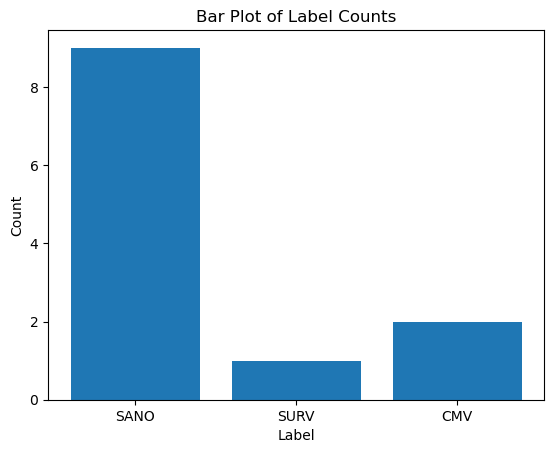

In [63]:
label_counts = df_test['Label'].value_counts()

# Create a bar plot
plt.bar(label_counts.index, label_counts.values)

# Set the labels and title
plt.xticks(label_counts.index, ["SANO","CMV", "SURV"])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Bar Plot of Label Counts')

# Show the plot
plt.show()

In [64]:
labels_train= df_train['Label']
train_list=[]
target_size = (224, 224)
folder= r'/home/jacobo15defrutos/AVS9/Data/fotos_segm2/'
for name in df_train['Name']:
    path= folder + name
    img=cv2.imread(path,cv2.IMREAD_GRAYSCALE) #,cv2.IMREAD_GRAYSCALE
    img= cv2.resize(img,target_size)
    train_list.append(img)
train= np.array(train_list)



# Convert the original labels to one-hot encoded labels
y_train = np.zeros((labels_train.shape[0], 3))
y_train[np.arange(labels_train.shape[0]), labels_train] = 1
x_train= train/255

In [65]:
labels_test= df_test['Label']
test_list=[]
target_size = (224, 224)
folder= '/home/jacobo15defrutos/AVS9/Data/fotos_segm2/'
for name in df_test['Name']:
    path= folder + name
    img=cv2.imread(path, cv2.IMREAD_GRAYSCALE)#, cv2.IMREAD_GRAYSCALE
    img= cv2.resize(img,target_size)
    test_list.append(img)

test= np.array(test_list)

x_test= test/255
# Convert the original labels to one-hot encoded labels
y_test = np.zeros((labels_test.shape[0], 3))
y_test[np.arange(labels_test.shape[0]), labels_test] = 1

In [75]:
x_total= np.concatenate((x_train,x_test),axis=0)
y_total= np.concatenate((y_train,y_test),axis=0)
# Define the K-fold Cross Validator
kfold = KFold(n_splits=4, shuffle=True)

In [73]:
def build_LeNet5_branch(input_shape):
    input_layer = Input(shape=input_shape)

    x = Conv2D(6, kernel_size=(5, 5), activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(16, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(120, activation='relu')(x)
    output_layer = Dense(84, activation='relu')(x)
    output_layer = Dense(3, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [76]:
fold_no=1
acc_per_fold=[]
loss_per_fold=[]
for train,test in kfold.split(x_total,y_total):    
    input_shape=(224, 224, 1)
    model= build_LeNet5_branch(input_shape)
    model = Model(inputs=model.input, outputs=model.output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss= 'categorical_crossentropy', metrics=['accuracy'])
    print("-"*10)
    print(f'Training for fold {fold_no} ...')
    h=model.fit(x=x_total[train], y=y_total[train], batch_size= 1, validation_split=0.15, epochs=10,verbose=1)
    scores = model.evaluate(x_total[test], y_total[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    fold_no = fold_no + 1
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
#model.summary()

----------
Training for fold 1 ...
Epoch 1/10
38/38 [==============================] - 2s 40ms/step - loss: 1.0618 - accuracy: 0.5000 - val_loss: 1.2512 - val_accuracy: 0.4286
Epoch 2/10
38/38 [==============================] - 1s 26ms/step - loss: 0.7047 - accuracy: 0.7105 - val_loss: 2.8341 - val_accuracy: 0.0000e+00
Epoch 3/10
38/38 [==============================] - 1s 29ms/step - loss: 0.3297 - accuracy: 0.8684 - val_loss: 3.8428 - val_accuracy: 0.1429
Epoch 4/10
38/38 [==============================] - 1s 22ms/step - loss: 0.1670 - accuracy: 0.9211 - val_loss: 4.9432 - val_accuracy: 0.5714
Epoch 5/10
38/38 [==============================] - 1s 29ms/step - loss: 0.0159 - accuracy: 1.0000 - val_loss: 5.6088 - val_accuracy: 0.4286
Epoch 6/10
38/38 [==============================] - 1s 36ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 6.1622 - val_accuracy: 0.4286
Epoch 7/10
38/38 [==============================] - 1s 32ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 6.52

In [ ]:
input_shape=(224, 224, 1)
model= build_LeNet5_branch(input_shape)
model = Model(inputs=model.input, outputs=model.output)
model.compile(optimizer=Adam(learning_rate=0.001), loss= 'categorical_crossentropy', metrics=['accuracy'])
h=model.fit(x=x_train, y=y_train, batch_size= 1, validation_split=0.15, epochs=10,verbose=1)

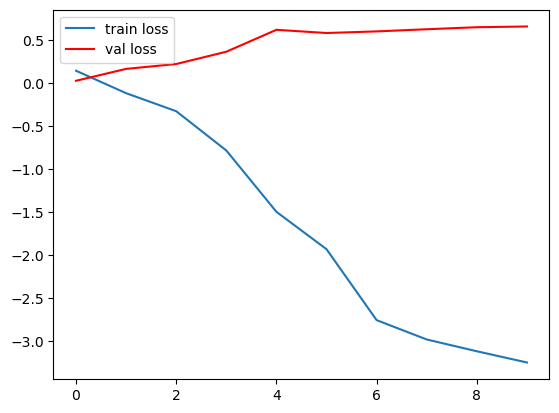

In [77]:
plt.plot(np.log10(h.history['loss']))
plt.plot(np.log10(h.history['val_loss']), 'r')
plt.legend(['train loss', 'val loss'])

train acc: 100.00 % 
val acc: 57.14 %


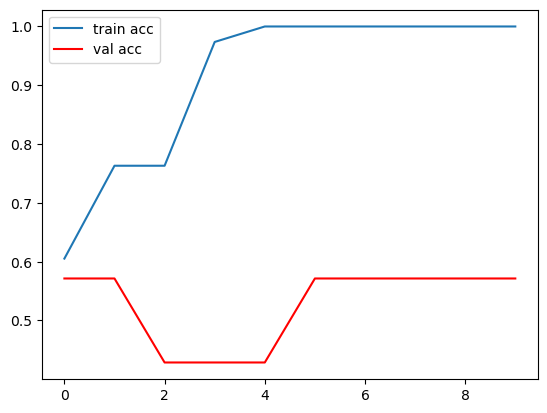

In [78]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'], 'r')
plt.legend(['train acc', 'val acc'])
print('train acc: %.2f %% \nval acc: %.2f %%'%(h.history['accuracy'][-1]*100,h.history['val_accuracy'][-1]*100))

In [79]:
pred=model.predict(x_test,verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
predicted_class_indices

1/1 [==============================] - 0s 68ms/step


array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

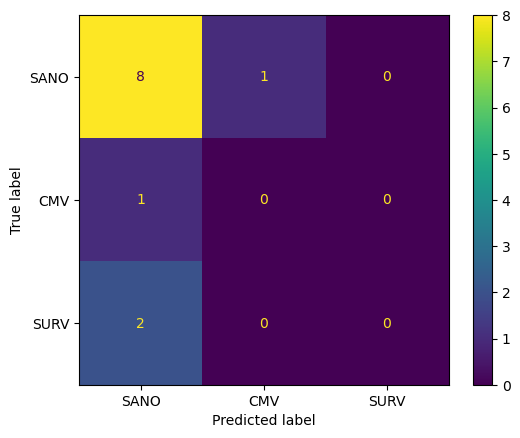

In [80]:
from sklearn.metrics import confusion_matrix
labels=df_test['Label'].astype(int).tolist()
confusion_matrix = metrics.confusion_matrix(labels, predicted_class_indices)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['SANO','CMV','SURV'])
cm_display.plot()
plt.show()

In [72]:
from sklearn.metrics import accuracy_score
labels=df_test['Label'].astype(int).tolist()
accuracy_score(labels,predicted_class_indices)

0.5833333333333334

(1, 224, 224)
(1, 1, 224, 224, 1)


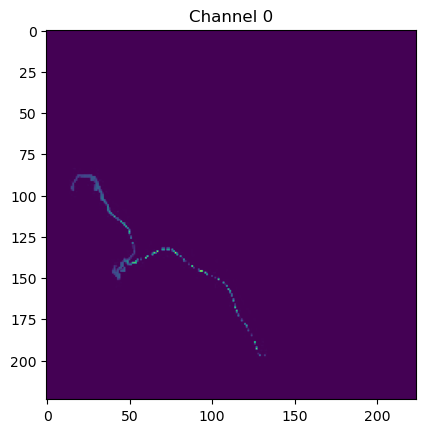

(1, 224, 224)
(1, 1, 220, 220, 6)


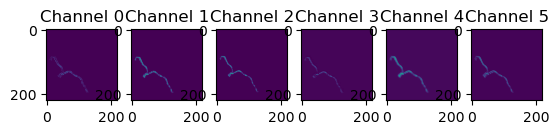

(1, 224, 224)
(1, 1, 110, 110, 6)


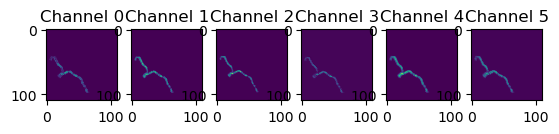

(1, 224, 224)
(1, 1, 108, 108, 16)


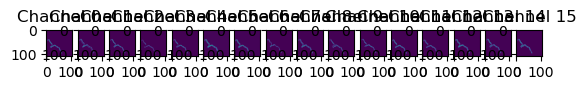

(1, 224, 224)
(1, 1, 54, 54, 16)


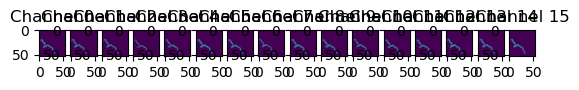

(1, 224, 224)
(1, 1, 46656)


IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

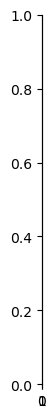

In [59]:
sample = x_test[0:1]
inp= model.input
outputs= [layer.output for layer in model.layers]
functors= [k.backend.function([inp],[out]) for out in outputs]
for layer_index,func in enumerate(functors):
    print(sample.shape)
    layer_output  = np.array(func([sample]))
    print(layer_output.shape)
    # Assuming layer_output has shape (1,1, height, width, channels)
    activations = layer_output[0,0]

    # Display the activations as images
    for i in range(activations.shape[-1]):
        plt.subplot(1, activations.shape[-1], i + 1)
        plt.imshow(activations[:, :, i], cmap='viridis')
        plt.title(f'Channel {i}')

    plt.show()



In [51]:
df_test['Name']

110      449702_OI_INF_CMV.jpg
141    9764955_OI_INF_SANO.jpg
131    9400239_OI_NAS_SANO.jpg
102      428663_OI_NAS_CMV.jpg
85     9369110_OI_TEM_SURV.jpg
150    2581150_OI_NAS_SANO.jpg
127     9533836_OI_TEM_CMV.jpg
64      9453167_OD_TEM_CMV.jpg
72     9381742_OD_TEM_SANO.jpg
45     9952305_OD_INF_SURV.jpg
91     9974807_OI_NAS_SANO.jpg
73      649387_OI_INF_SURV.jpg
21      440297_OD_NAS_SANO.jpg
36     9381742_OD_SUP_SANO.jpg
13     9301219_OD_NAS_SANO.jpg
15     9764955_OD_SUP_SURV.jpg
149     649387_OI_NAS_SURV.jpg
121     9494783_OI_INF_CMV.jpg
54     9369110_OD_INF_SURV.jpg
17      9455268_OD_NAS_CMV.jpg
37      428663_OD_NAS_SANO.jpg
43     9816130_OD_SUP_SANO.jpg
134    9453167_OI_INF_SANO.jpg
109      449702_OI_SUP_CMV.jpg
8       649387_OD_NAS_SANO.jpg
62     9369110_OD_SUP_SURV.jpg
80       428663_OI_INF_CMV.jpg
119      742291_OI_SUP_CMV.jpg
133    9655394_OI_INF_SANO.jpg
47     9400239_OD_INF_SURV.jpg
96     9655394_OI_NAS_SANO.jpg
Name: Name, dtype: object